In [1]:
import os
import sys
import pyrootutils

pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
sys.path.append('..')
sys.path.append('')


In [2]:
from typing import Optional

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from tdc.generation import MolGen
from tdc.single_pred import Tox

from representation.src.actions.smiles.cleaning import SmilesCleaning
from representation.src.actions.smiles.enumeration import SmilesEnumeration
from representation.src.actions.smiles.filtering import DropAllNA, DropDuplicates
from representation.src.actions.smiles.physchem_calculation import PhyschemCalculation


Find root:

In [3]:
ROOT = str(pyrootutils.find_root())
DATA_FOLDER = "data"


Import Ames from TDC

In [4]:
data = Tox(name="AMES")
dfs = data.get_split(method="random")
df = pd.concat({k: dfs[k] for k in ["test", "valid", "train"]}, axis=0)
df = df.reset_index(level=0, drop=False).rename(columns={"level_0": "split"}).reset_index(drop=True)


Found local copy...
Loading...
Done!


In [5]:
data = Tox(name="AMES")

scaffold_dfs = data.get_split(method="scaffold")
scaffold = pd.concat({k: dfs[k] for k in ["test", "valid", "train"]}, axis=0)
scaffold = scaffold.reset_index(level=0, drop=False).rename(columns={"level_0": "scaffold"}).reset_index(drop=True)

random_dfs = data.get_split(method="random")
random = pd.concat({k: dfs[k] for k in ["test", "valid", "train"]}, axis=0)
random = random.reset_index(level=0, drop=False).rename(columns={"level_0": "random"}).reset_index(drop=True)

df = scaffold.merge(random[["Drug_ID", "random"]], on="Drug_ID", how="left")


Found local copy...
Loading...
Done!
100%|██████████| 7278/7278 [00:01<00:00, 5403.78it/s]


In [6]:
df.head()


,scaffold,Drug_ID,Drug,Y,random
0,test,Drug 6060,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,1,test
1,test,Drug 6703,CN(CC(O)CO)N=O,1,test
2,test,Drug 6827,O=[N+]([O-])c1ccc(OC2CO2)cc1,1,test
3,test,Drug 3689,Cn1cnc2cc([N+](=O)[O-])ccc21,0,test
4,test,Drug 4516,CC[C@H](CO)NCCN[C@H](CC)CO,0,test


Quick data overview

In [7]:
original_length = len(df)
random_lengths = df["random"].value_counts().to_dict()
scaffold_lengths = df["scaffold"].value_counts().to_dict()
Y_lengths = df["Y"].value_counts().to_dict()


# Data Cleaning

In [8]:
clean_action = SmilesCleaning(
    input_columns="Drug",
    output_columns="canonical_smiles",
    verbose=False,
    logger=None,
    sanitize=True,
    remove_salts=True,
    remove_stereo=True, #True,
    remove_metal_atoms=False,
    keep_largest_fragment=True,
    neutralize_mol=False,
    standardize_tautomers=False,
    remove_duplicates=False,
    canonicalize_smiles=True,
    limit_seq_len=None,
    constrains=None,
)
drop_dups = DropDuplicates(input_column=["canonical_smiles"])
drop_na = DropAllNA()
clean_df = clean_action.batchify(df, batch_size=2048)


100%|██████████| 1134/1134 [00:00<00:00, 16695.77it/s]
0it [00:00, ?it/s]/5 [00:16<00:03,  3.88s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


In [9]:
clean_df = drop_dups(clean_df)
clean_df = drop_na(clean_df)
print(f"Data went from {original_length} smiles to {len(clean_df)}.")


Data went from 7278 smiles to 6722.


In [11]:
print(clean_df[clean_df['scaffold']=='train']['Y'].value_counts().to_dict())
print(clean_df[clean_df['scaffold']=='valid']['Y'].value_counts().to_dict())
print(clean_df[clean_df['scaffold']=='test']['Y'].value_counts().to_dict())


{1: 2470, 0: 2141}
{1: 391, 0: 297}
{1: 776, 0: 647}


In [ ]:
original_length = len(df)
random_lengths = df["random"].value_counts().to_dict()
scaffold_lengths = df["scaffold"].value_counts().to_dict()
Y_lengths = df["Y"].value_counts().to_dict()


In [65]:
clean_df = drop_dups(clean_df)
clean_df = drop_na(clean_df)
print(f"Data went from {original_length} smiles to {len(clean_df)}.")


Data went from 7278 smiles to 7247.


# Data analysis

175


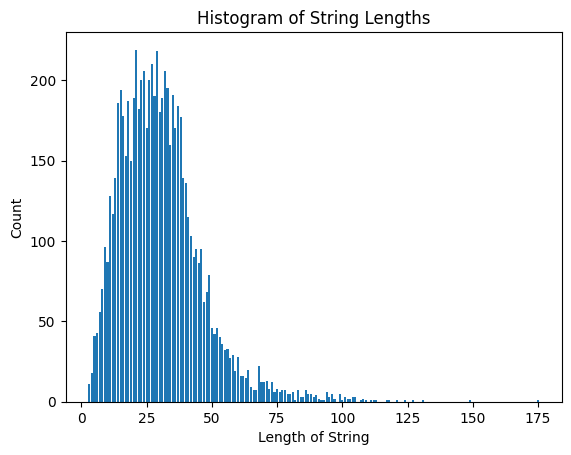

In [66]:
# get the lengths of the strings in the first column
lengths = clean_df[["canonical_smiles"]].iloc[:, 0].str.len()

# count the occurrence of each length
counter = Counter(lengths)
print(max(lengths))

# create a new DataFrame for the result
result = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result.columns = ['Length', 'Count']

# sort by the 'Length' column
result.sort_values('Length', inplace=True)

# reset the index for the DataFrame
result.reset_index(drop=True, inplace=True)

# create a histogram
plt.bar(result['Length'], result['Count'])
plt.xlabel('Length of String')
plt.ylabel('Count')
plt.title('Histogram of String Lengths')
plt.show()
